# In this assignment we learn about numerical stability of the covariance matrix, fitting $\chi^2$ distributions, to correct for the Hartlap factor.

## For this assignment no external packages are required. You just need a running conda environment, where numpy and matplotlib are installed.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv, eigvals
from scipy.special import gamma, factorial
from scipy.optimize import curve_fit
from scipy.stats import chi2 as chi2_scp

In [2]:
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

## Preparation: load in the data we need for this assignment.

In [3]:
model=np.load('data_4_assignment1/reference_model.npy') # This will be our reference model
cov=np.load('data_4_assignment1/covariance.npy') # This is the analytical covariance matrix, which we assume is the true covariance of the data

## Task 1: Create two sets of 10000 noisy Gaussian data vectors each using the provided reference model and true covariance matrix. 

In [4]:
noisy_data_set1 = np.random.multivariate_normal(model,cov,10000)
noisy_data_set2 = np.random.multivariate_normal(model,cov,10000)

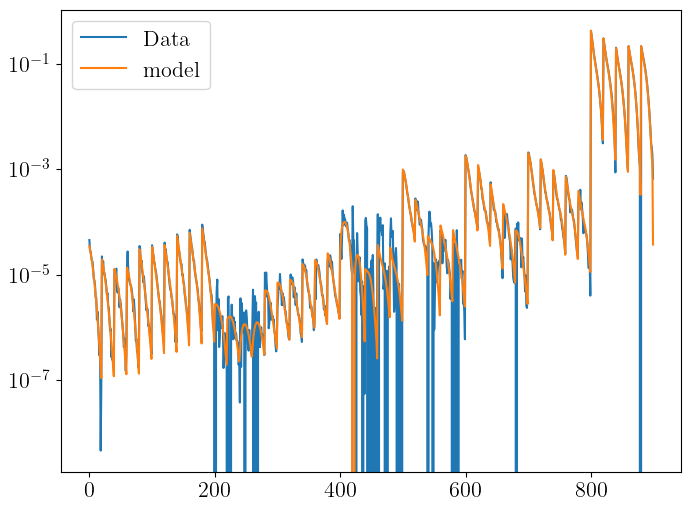

In [5]:
# check that the noisy data vector scatter around the truth
plt.figure(figsize=(8,6),dpi=100)
plt.plot(noisy_data_set1[0],label='Data')
plt.plot(model,label='model')
plt.yscale('log')
plt.legend()
plt.show()

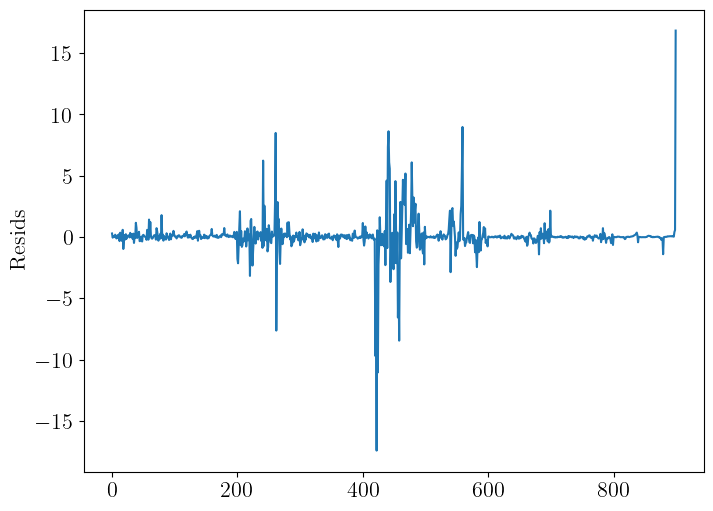

In [6]:
resids = (noisy_data_set1[0] - model) / model

plt.figure(figsize=(8,6),dpi=100)
plt.ylabel('Resids')
plt.plot(resids)
#plt.yscale('log')
plt.show()

## Task 2: 
#### Use the provided covariance matrix and the model as a reference.
### 2.1: Test if set 1 follows a $\chi^2$ distribution with the correct degrees of freedom, by measuring its mean and variance. 
### 2.2: Convince yourself, that the measured $\chi^2$ follows a $\chi^2$ distribution.

mean:		 899.7888598074015
variance:	 1804.8988790749352
ratio:		 2.00591378677579


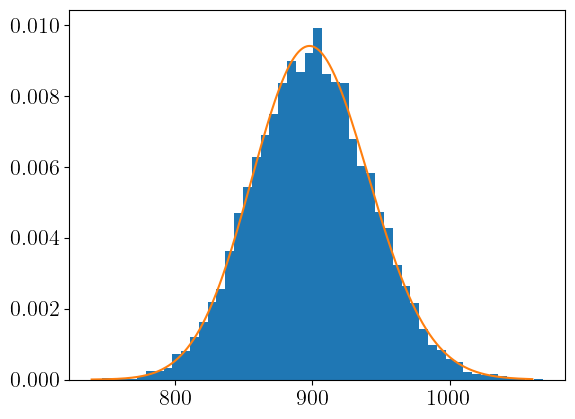

In [7]:
inv_cov = inv(cov)

chi2 = []
for i in range(len(noisy_data_set1)):
    diff = model - noisy_data_set1[i]
    chi2.append(diff.T @ inv_cov @ diff)
# compute the chi^2 for all dv 


# What should the mean and variance be?

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension
print('ratio:\t\t',var/mean) # var/mean = 2



# is the overall distribution right?
spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)
#hist=np.histogram(chi2)
#plt.plot(hist)
plt.figure()
plt.hist(chi2,50,density=True)
plt.plot(x,chi2_scp.pdf(x,900)) #plt.plot(...,chi2_scp.pdf(...,...))
plt.show()

# no data fit --> degrees of freedom = dimension of data vector
# for fit data --> degrees of freedom = dimension of data - number of free parameters

### After convincing us that the two sets actually follow a $\chi^2$ distribution, if we use the analytical covariance matrix, we want to check if that is also true if we measure the covariance matrix from simulations. 
### As running simulations is too expensive, we simulate measurements from simulations with the created set 2. 
### Task 3: As a preparation, please measure the numerical covariance matrix from [500,1000,5000,10000] data vectors from set 2. What do you observe in the correlation matrix? Are the covariances positive semi-definite?

In [8]:
cov_num500 = np.cov(noisy_data_set2[:500].T)
cov_num1000 = np.cov(noisy_data_set2[:1000].T)
cov_num5000 = np.cov(noisy_data_set2[:5000].T)
cov_num10000 = np.cov(noisy_data_set2[:10000].T)

In [9]:
eigs500 = eigvals(cov_num500)
eigs1000 = eigvals(cov_num1000)
eigs5000 = eigvals(cov_num5000)
eigs10000 = eigvals(cov_num10000)

print(np.any(eigs500<0)) # true because fewer realisations than dimension
print(np.any(eigs1000<0)) # false because more realisations than dimension
print(np.any(eigs5000<0)) # ^
print(np.any(eigs10000<0)) # ^

True
False
False
False


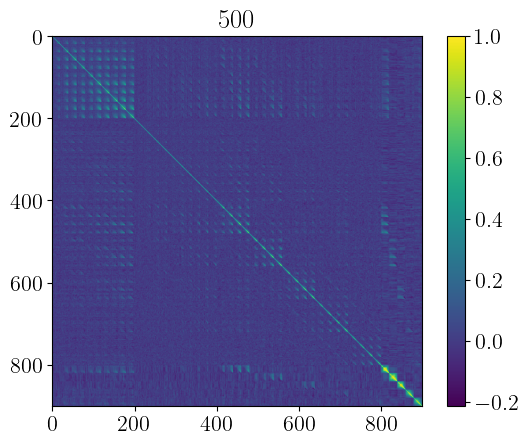

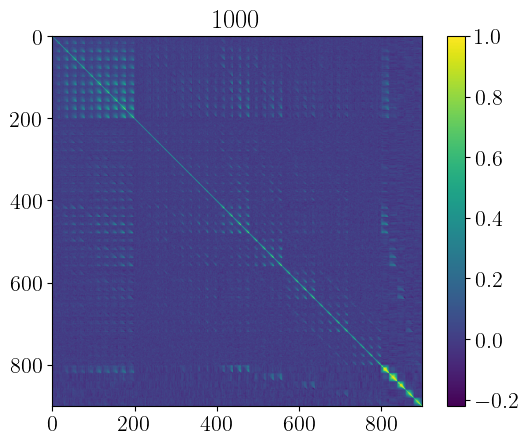

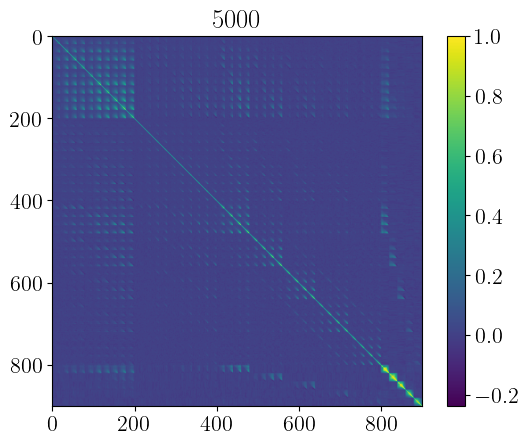

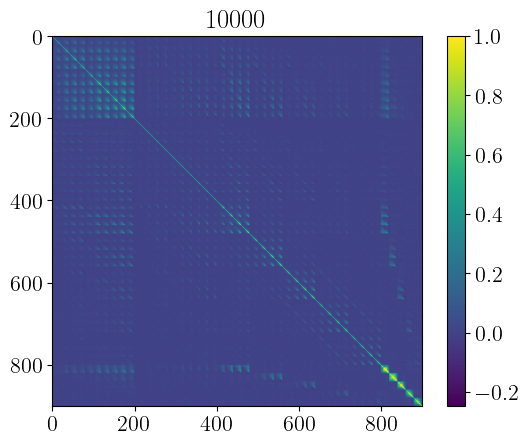

In [10]:
corr500 = cov_num500/np.outer(np.sqrt(np.diag(cov_num500)),np.sqrt(np.diag(cov_num500)))
corr1000 = cov_num1000/np.outer(np.sqrt(np.diag(cov_num1000)),np.sqrt(np.diag(cov_num1000)))
corr5000 = cov_num5000/np.outer(np.sqrt(np.diag(cov_num5000)),np.sqrt(np.diag(cov_num5000)))
corr10000 = cov_num10000/np.outer(np.sqrt(np.diag(cov_num10000)),np.sqrt(np.diag(cov_num10000)))

plt.title('500')
plt.imshow(corr500)
plt.colorbar()
plt.show()

plt.title('1000')
plt.imshow(corr1000)
plt.colorbar()
plt.show()

plt.title('5000')
plt.imshow(corr5000)
plt.colorbar()
plt.show()

plt.title('10000')
plt.imshow(corr10000)
plt.colorbar()
plt.show()

# positive semi-definite: x^T C x >= 0  ,  (upsidedown A) x (epsilon) (real numbers)^n

# number of realisations must be more than rank of covariance matrix

### Task 4: Test for all four covariance matrices if you recover a $\chi^2$ distribution with the mean and variance. What do you observe? 

mean:		 8091597076852064.0
variance:	 1.8409438952545467e+34


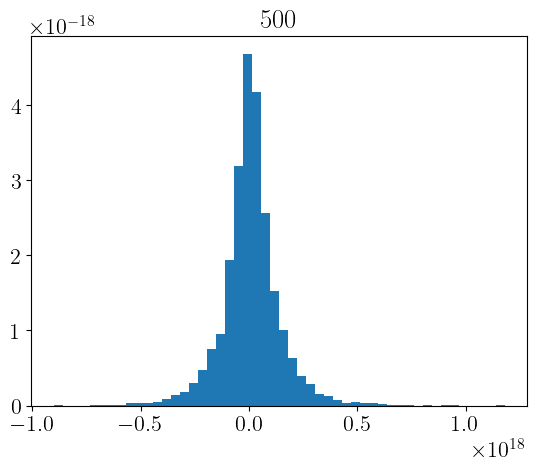

mean:		 8965.700854455601
variance:	 1785642.6371216194


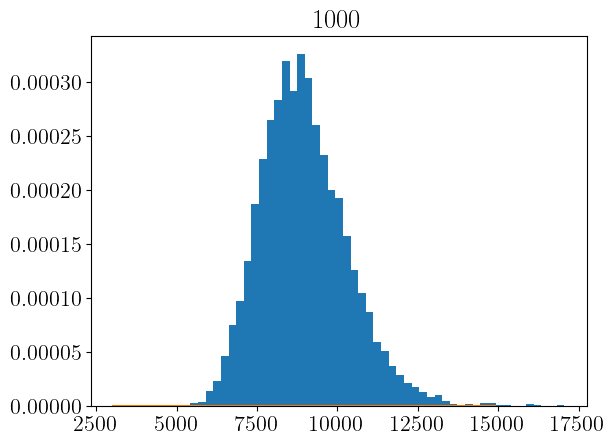

mean:		 1097.7000682819807
variance:	 3286.155250645818


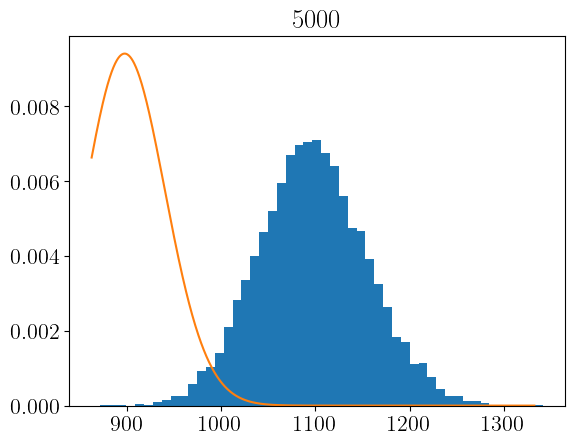

mean:		 989.1101817050611
variance:	 2411.1412941464505


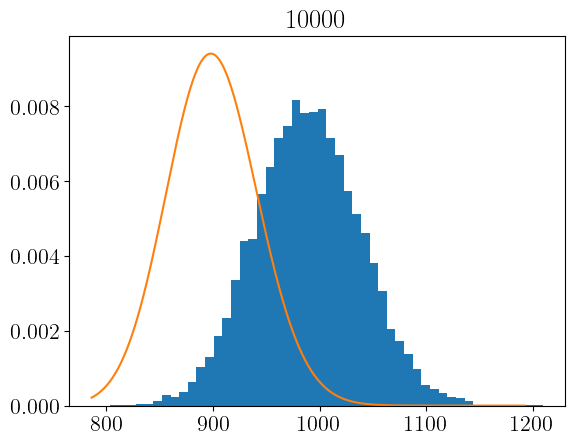

In [11]:
# use the first data set since the second was used to make the covariance matrices

# 500
inv_cov = inv(cov_num500)
chi2 = []
for i in range(10000):
    diff = model - noisy_data_set1[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('500')
plt.hist(chi2,50,density=True)
plt.show()


# 1000
inv_cov = inv(cov_num1000)
chi2 = []
for i in range(10000):
    diff = model - noisy_data_set1[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('1000')
plt.hist(chi2,50,density=True)
plt.plot(x,chi2_scp.pdf(x,900))
plt.show()


# 5000
inv_cov = inv(cov_num5000)
chi2 = []
for i in range(10000):
    diff = model - noisy_data_set1[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('5000')
plt.hist(chi2,50,density=True)
plt.plot(x,chi2_scp.pdf(x,900))
plt.show()


# 10000
inv_cov = inv(cov_num10000)
chi2 = []
for i in range(10000):
    diff = model - noisy_data_set1[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('10000')
plt.hist(chi2,50,density=True)
plt.plot(x,chi2_scp.pdf(x,900))
plt.show()

#print(mean and variance)

#comment your result

#Do it for the covariance matrices



### Task 5: Repeat the same exercise from before, but debias your inverse covriance matrix with the so-called Hartlap factor. What do you observe?

mean:		 -6518681412614288.0
variance:	 1.1947899697138394e+34


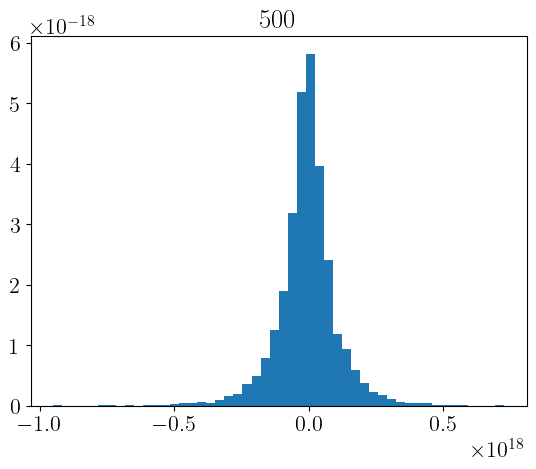

mean:		 879.5182019385875
variance:	 17183.662027308623


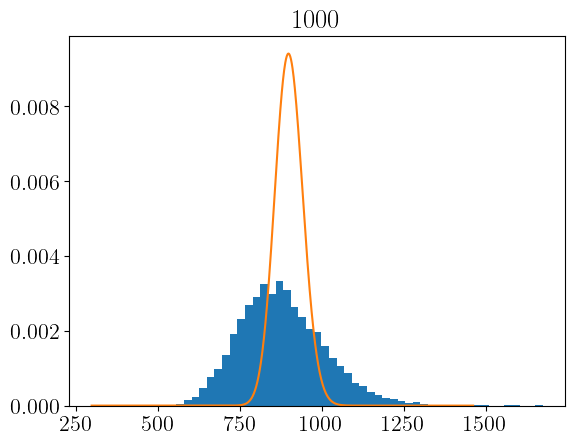

mean:		 899.8549469533023
variance:	 2208.3388456793823


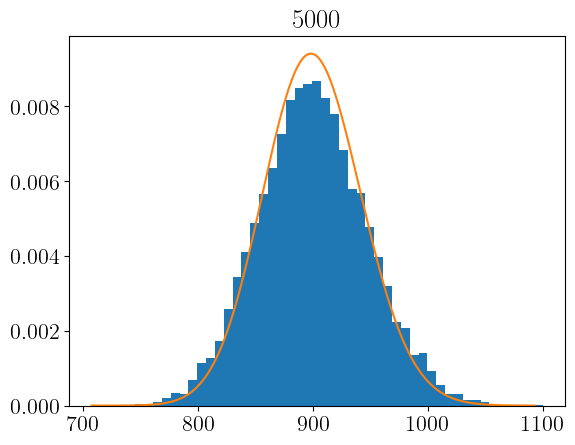

mean:		 899.9824415594207
variance:	 1996.187764288239


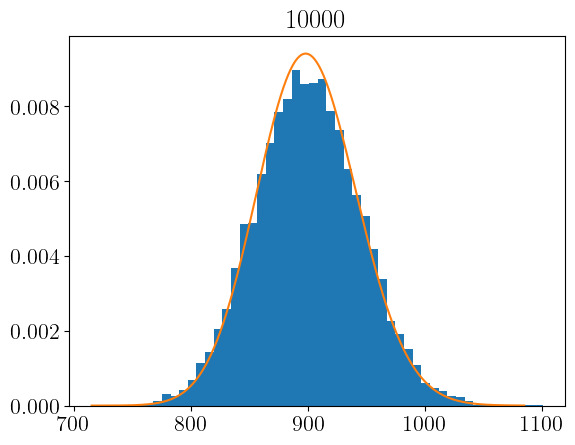

In [12]:
#.... plot and check mean and variance
# 500
n_r = 500
n_d = 900
h = (n_r-1)/(n_r-n_d-2)
inv_cov = inv(cov_num500)/h

chi2 = []
for i in range(10000):
    diff = model - noisy_data_set1[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('500')
plt.hist(chi2,50,density=True)
plt.show()


# 1000
n_r = 1000
n_d = 900
h = (n_r-1)/(n_r-n_d-2)
inv_cov = inv(cov_num1000)/h

chi2 = []
for i in range(10000):
    diff = model - noisy_data_set1[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('1000')
plt.hist(chi2,50,density=True)
plt.plot(x,chi2_scp.pdf(x,900))
plt.show()


# 5000
n_r = 5000
n_d = 900
h = (n_r-1)/(n_r-n_d-2)
inv_cov = inv(cov_num5000)/h

chi2 = []
for i in range(10000):
    diff = model - noisy_data_set1[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('5000')
plt.hist(chi2,50,density=True)
plt.plot(x,chi2_scp.pdf(x,900))
plt.show()


# 10000
n_r = 10000
n_d = 900
h = (n_r-1)/(n_r-n_d-2)
inv_cov = inv(cov_num10000)/h

chi2 = []
for i in range(10000):
    diff = model - noisy_data_set1[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('10000')
plt.hist(chi2,50,density=True)
plt.plot(x,chi2_scp.pdf(x,900))
plt.show()

### Task 6: Repeat task 5 again, but this time, test if set 2 also follows a $\chi^2$ distribution. What do you observe?

mean:		 -5396165108442731.0
variance:	 1.1282700970385181e+34


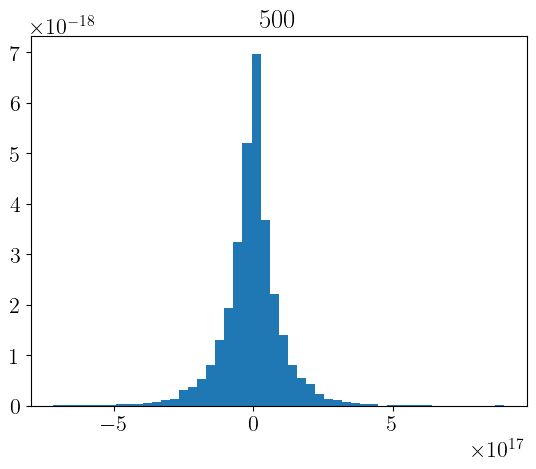

mean:		 798.5753183866893
variance:	 71071.18195675813


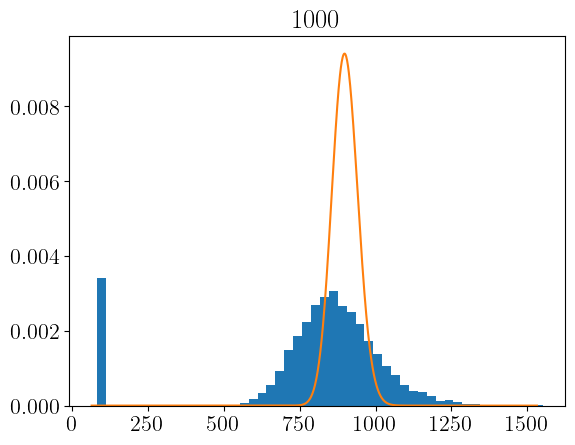

mean:		 819.0965717287573
variance:	 8164.080483583286


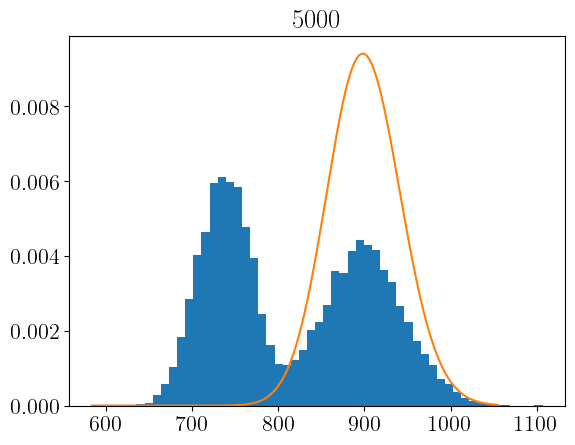

mean:		 818.9110199319537
variance:	 1324.3734555877402


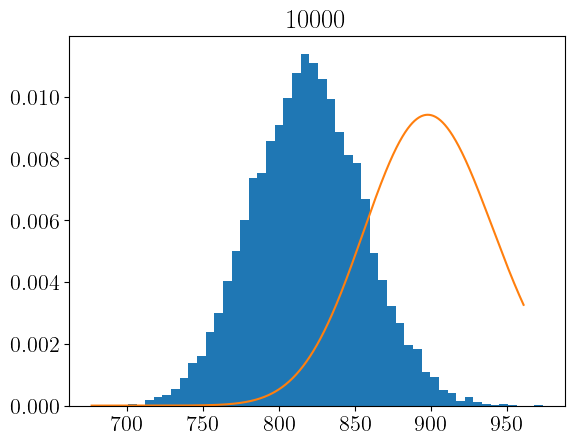

In [13]:
# 500
n_r = 500
n_d = 900
h = (n_r-1)/(n_r-n_d-2)
inv_cov = inv(cov_num500)/h

chi2 = []
for i in range(10000):
    diff = model - noisy_data_set2[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('500')
plt.hist(chi2,50,density=True)
plt.show()


# 1000
n_r = 1000
n_d = 900
h = (n_r-1)/(n_r-n_d-2)
inv_cov = inv(cov_num1000)/h

chi2 = []
for i in range(10000):
    diff = model - noisy_data_set2[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('1000')
plt.hist(chi2,50,density=True)
plt.plot(x,chi2_scp.pdf(x,900))
plt.show()


# 5000
n_r = 5000
n_d = 900
h = (n_r-1)/(n_r-n_d-2)
inv_cov = inv(cov_num5000)/h

chi2 = []
for i in range(10000):
    diff = model - noisy_data_set2[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('5000')
plt.hist(chi2,50,density=True)
plt.plot(x,chi2_scp.pdf(x,900))
plt.show()


# 10000
n_r = 10000
n_d = 900
h = (n_r-1)/(n_r-n_d-2)
inv_cov = inv(cov_num10000)/h

chi2 = []
for i in range(10000):
    diff = model - noisy_data_set2[i]
    chi2.append(diff.T @ inv_cov @ diff)

mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t',mean) # mean = dimension
print('variance:\t',var) # var = 2*dimension

spread = np.max(chi2) - np.min(chi2)
x = np.linspace(mean-spread/2,mean+spread/2,1000)

plt.title('10000')
plt.hist(chi2,50,density=True)
plt.plot(x,chi2_scp.pdf(x,900))
plt.show()
    
# what is happening in comparison to the taak before?

# The covariance matrix is correlated with the data since set2 was used to generate the covariance matrix,
# so the covariance matrix is too large, and the chi2 is thus too low.
# I think that we get too peaks because the data used for the covariance is low, and that which isn't is not.

### Bonus Task 1: Create a new set of 10000 noisy data vectors using the numerical covariance matrix measured from 1000 noisy data vectors. Is it possible to reduce the noise in the covariance matrix with this method? Test if set 1 follows a $\chi^2$ distribution which the newly created covaraince matrix. What do you observe?

In [14]:
noisy_data_set3=np.random.multivariate_normal(...)
cov_num10000_set3 = np.cov(...)



TypeError: multivariate_normal() takes at least 2 positional arguments (1 given)

### Bonus task 2: What is the minimum number of data vectors such that the inverse covariance matrix is non-singular? What is an easy tool to test this? Is an analytical covariance matrix always invertible? What can you do if it is not invertible? 